In [80]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
work_dfs = {}
for file in glob("./cultivos/*.csv"):
    df = pd.read_csv(file)
    filename= Path(file).stem
    work_dfs[filename] = df
    
work_dfs.keys()

dict_keys(['Barley', 'Oilseeds_total', 'Rice', 'Sweet_potato', 'Tapioca'])

## Preprocesamiento para modelado

In [70]:
# for name, df in work_dfs.items():
grouped = work_dfs["Barley"].set_index("Crop_Year")
X_train, X_test, y_train, y_test = train_test_split(grouped.drop("Yield", axis=1), grouped["Yield"], test_size=0.2, random_state=42)


Mejor alpha: {'regressor__alpha': 0.1}
RMSE: 2.00
MAE: 1.89


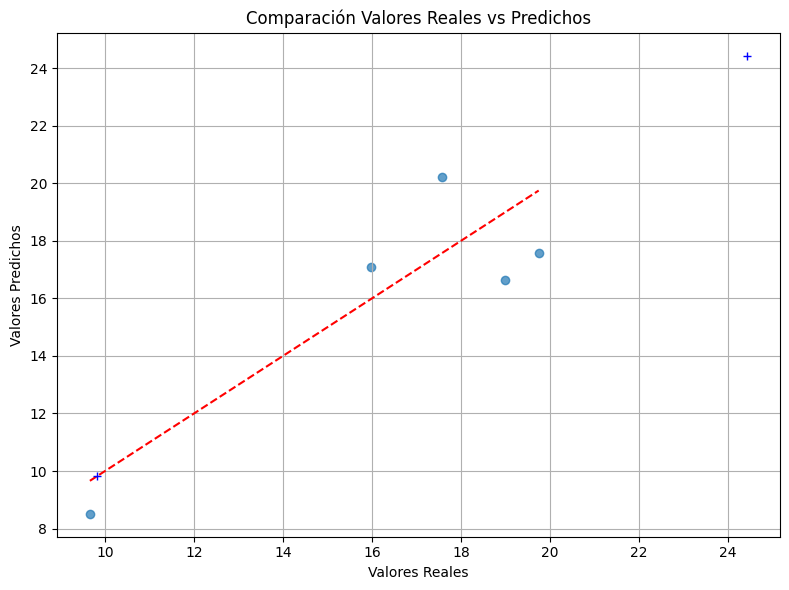

In [ ]:
# Crear pipeline: StandardScaler + LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])
# GridSearch
param_grid = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Mejor alpha: {grid_search.best_params_}")

# Predicción con el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Gráfico de comparación
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Comparación Valores Reales vs Predichos')
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(grouped.drop("Yield", axis=1), grouped["Yield"], test_size=0.2, random_state=42)

# Definir los modelos en un diccionario con sus parámetros
pipelines = {
    'Ridge': Pipeline([('scaler', StandardScaler()), ('regressor', Ridge())]),
    'RandomForest': Pipeline([('scaler', StandardScaler()), ('regressor', RandomForestRegressor(random_state=42))]),
    'MLP': Pipeline([('scaler', StandardScaler()), ('regressor', MLPRegressor(max_iter=5000, random_state=42))])
}

param_grids = {
    'Ridge': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'RandomForest': {'regressor__n_estimators': [50, 100], 'regressor__max_depth': [None, 5]},
    'MLP': {'regressor__hidden_layer_sizes': [(50,), (100,)], 'regressor__alpha': [0.0001, 0.001]}
}

# Ejecutar GridSearch para cada modelo
mejores_resultados = {}

for nombre, pipeline in pipelines.items():
    grid = GridSearchCV(pipeline, param_grids[nombre], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mejores_resultados[nombre] = {'BestParams': grid.best_params_, 'RMSE': rmse}

# Mostrar resultados
for modelo, resultado in mejores_resultados.items():
    print(f"Modelo: {modelo}")
    print(f"Mejores Parámetros: {resultado['BestParams']}")
    print(f"RMSE: {resultado['RMSE']:.2f}")
    print("-" * 30)


Modelo: Ridge
Mejores Parámetros: {'regressor__alpha': 0.1}
RMSE: 2.00
------------------------------
Modelo: RandomForest
Mejores Parámetros: {'regressor__max_depth': None, 'regressor__n_estimators': 50}
RMSE: 2.33
------------------------------
Modelo: MLP
Mejores Parámetros: {'regressor__alpha': 0.001, 'regressor__hidden_layer_sizes': (100,)}
RMSE: 2.39
------------------------------


         Modelo      RMSE                                 Mejores Parámetros
0         Ridge  1.995557                          {'regressor__alpha': 0.1}
1  RandomForest  2.325264  {'regressor__max_depth': None, 'regressor__n_e...
2           MLP  2.390534  {'regressor__alpha': 0.001, 'regressor__hidden...


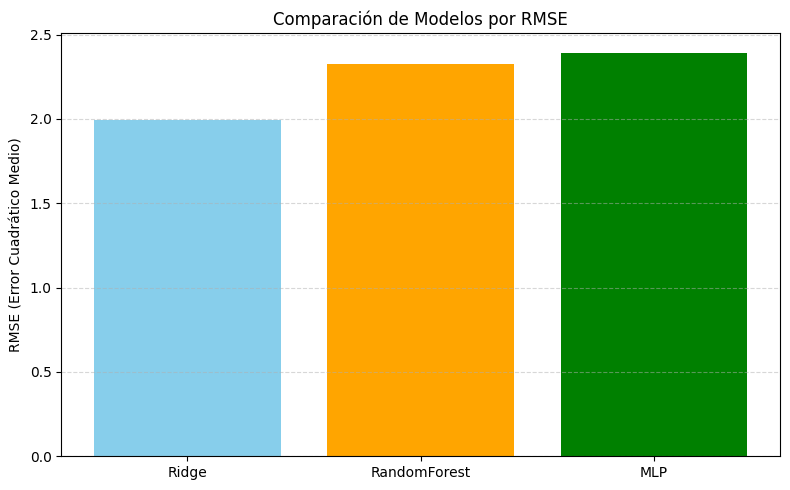

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Usamos el diccionario mejores_resultados del ejemplo anterior:

# Convertir a DataFrame para mostrar en tabla
resultados_df = pd.DataFrame([
    {'Modelo': modelo, 'RMSE': datos['RMSE'], 'Mejores Parámetros': datos['BestParams']}
    for modelo, datos in mejores_resultados.items()
])

print(resultados_df)

# Gráfico de barras para comparar RMSE
plt.figure(figsize=(8, 5))
plt.bar(resultados_df['Modelo'], resultados_df['RMSE'], color=['skyblue', 'orange', 'green'])
plt.ylabel('RMSE (Error Cuadrático Medio)')
plt.title('Comparación de Modelos por RMSE')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
